In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
Rhoop = 3 # the radius of the hoop
r0 = 1 # the equilibrial length of the springs
kappa = 1 # the spring constant
Nnodes = 21
A = np.zeros((Nnodes,Nnodes),dtype = int) # spring adjacency matrix
# vertical springs
for k in range(3):
    A[k,k+4] = 1
for k in range(4,7):  
    A[k,k+5] = 1
for k in range(9,12):  
    A[k,k+5] = 1
for k in range(14,17):  
    A[k,k+4] = 1
# horizontal springs
for k in range(3,7):
    A[k,k+1] = 1
for k in range(8,12):  
    A[k,k+1] = 1
for k in range(13,17):  
    A[k,k+1] = 1
# symmetrize
Asymm = A + np.transpose(A)
# indices of nodes on the hoop
ind_hoop = [0,3,8,13,18,19,20,17,12,7,2,1]
Nhoop = np.size(ind_hoop)
# indices of free nodes (not attached to the hoop)
ind_free = [4,5,6,9,10,11,14,15,16]
Nfree = np.size(ind_free)
# list of springs
springs = np.array(np.nonzero(A))

Nsprings = np.size(springs,axis=1)
print(springs)


[[ 0  1  2  3  4  4  5  5  6  6  8  9  9 10 10 11 11 13 14 14 15 15 16 16]
 [ 4  5  6  4  5  9  6 10  7 11  9 10 14 11 15 12 16 14 15 18 16 19 17 20]]


In [4]:
# Initialization

# Initial angles for the nodes are uniformly distributed around the range of 2*pi
# startting from theta0 and going counterclockwise
theta0 = 2*np.pi/3
theta = theta0 + np.linspace(0,2*np.pi,Nhoop+1)
theta = np.delete(theta,-1)
# Initial positions
pos = np.zeros((Nnodes,2))
pos[ind_hoop,0] = Rhoop*np.cos(theta)
pos[ind_hoop,1] = Rhoop*np.sin(theta)
pos[ind_free,0] = np.array([-1.,0.,1.,-1.,0.,1.,-1.,0.,1.])
pos[ind_free,1] = np.array([1.,1.,1.,0.,0.,0.,-1.,-1.,-1.]) 

# Initiallize the vector of parameters to be optimized
vec = np.concatenate((theta,pos[ind_free,0],pos[ind_free,1]))

In [5]:
def draw_spring_system(pos,springs,R,ind_hoop,ind_free):
    # draw the hoop
    t = np.linspace(0,2*np.pi,200)
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.plot(R*np.cos(t),R*np.sin(t),linewidth = 5,color = 'red')
    # plot springs
    Nsprings = np.size(springs,axis=1)
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        plt.plot([pos[j0,0],pos[j1,0]],[pos[j0,1],pos[j1,1]],color = 'black',linewidth = 3)    
    # plot nodes
    plt.scatter(pos[ind_hoop,0],pos[ind_hoop,1],s = 300,color = 'crimson')
    plt.scatter(pos[ind_free,0],pos[ind_free,1],s = 300,color = 'black')

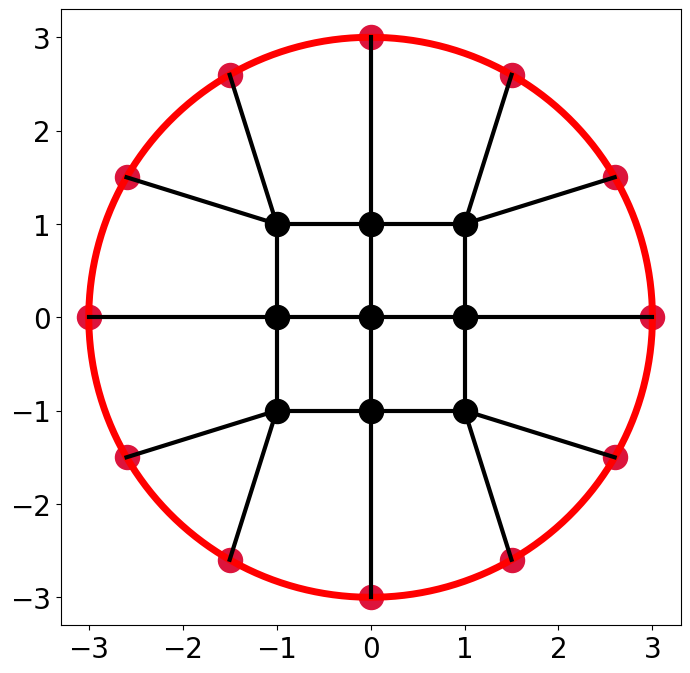

In [6]:
# Draw the initial configuration of the spring system
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)

In [7]:
def compute_gradient(theta,pos,Asymm,r0,kappa,R,ind_hoop,ind_free):
    Nhoop = np.size(ind_hoop)
    g_hoop = np.zeros((Nhoop,)) # gradient with respect to the angles of the hoop nodes
    Nfree = np.size(ind_free)
    g_free = np.zeros((Nfree,2)) # gradient with respect to the x- and y-components of the free nodes
    for k in range(Nhoop):
        ind = np.squeeze(np.nonzero(Asymm[ind_hoop[k],:])) # index of the node adjacent to the kth node on the hoop
        rvec = pos[ind_hoop[k],:] - pos[ind,:] # the vector from that adjacent node to the kth node on the hoop
        rvec_length = np.linalg.norm(rvec) # the length of this vector
        # print(k,ind,ind_hoop[k],rvec)
        g_hoop[k] = (rvec_length - r0)*R*kappa*(rvec[0]*(-np.sin(theta[k])) + rvec[1]*np.cos(theta[k]))/rvec_length
    for k in range(Nfree):
        ind = np.squeeze(np.array(np.nonzero(Asymm[ind_free[k],:]))) # indices of the nodes adjacent to the kth free node
        Nneib = np.size(ind)
        for j in range(Nneib):
            rvec = pos[ind_free[k],:] - pos[ind[j],:] # the vector from the jth adjacent node to the kth free node 
            rvec_length = np.linalg.norm(rvec) # the length of this vector
            g_free[k,:] = g_free[k,:] + (rvec_length - r0)*R*kappa*rvec/rvec_length
    # return a single 1D vector
    return np.concatenate((g_hoop,g_free[:,0],g_free[:,1]))     

def Energy(theta,pos,springs,r0,kappa):
    Nsprings = np.size(springs,axis = 1)
    E = 0.
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        rvec = pos[j0,:] - pos[j1,:]
        rvec_length = np.linalg.norm(rvec)        
        E = E + kappa*(rvec_length - r0)**2
    E = E*0.5
    return E
    

In [8]:
def vec_to_pos(vec):
    theta = vec[:Nhoop]
    pos[ind_hoop,0] = Rhoop*np.cos(theta)
    pos[ind_hoop,1] = Rhoop*np.sin(theta)
    # positions of the free nodes
    pos[ind_free,0] = vec[Nhoop:Nnodes]
    pos[ind_free,1] = vec[Nnodes:] 
    return theta,pos

def gradient(vec):
    theta,pos = vec_to_pos(vec) 
    return compute_gradient(theta,pos,Asymm,r0,kappa,Rhoop,ind_hoop,ind_free)

def func(vec):
    theta,pos = vec_to_pos(vec) 
    return Energy(theta,pos,springs,r0,kappa)
